# Demo 3 - Create an Animation

ROMY data of an M6.8 event in 2023 is analyzed loading data from a local MSEED file.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots import animate_waveforms

## Configurations

Here we load the data from a local mseed file (data_source = "mseed_file"). All parameters for the processing and plotting are set hereafter in the configuration dictionary.

In the MSEED file the station was renamed to XX.ROMY..*

In [7]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["XX.ROMY..BJZ", "XX.ROMY..BJN", "XX.ROMY..BJE"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["XX.ROMY..BHZ", "XX.ROMY..BHN", "XX.ROMY..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"

    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'twin_sec': 30,          # Window length in seconds
    'twin_overlap': 0.5,  # Window overlap in seconds
    'cc_threshold': 0.75,        # Cross-correlation threshold

    # Filter parameters
    'fmin': 0.02,               # Minimum frequency for filtering
    'fmax': 0.2,                # Maximum frequency for filtering
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

In [10]:
config = sixdegrees.load_from_yaml("./config/config_ROMY_M6.8_20230908_file.yml")

Setup a sixdegrees object

In [11]:
sd = sixdegrees(conf=config)

Get key information about the event

In [12]:
ev = sd.get_event_info(
    origin_time=config['origin_time'],
    base_catalog="USGS",
    magnitude=config['magnitude']
)

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.0 km
Epicentral Distance: 22.7°
Backazimuth: 228.4°


In [13]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching XX.ROMY..BHZ data from mseed file
-> fetching XX.ROMY..BHN data from mseed file
-> fetching XX.ROMY..BHE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
-> fetching XX.ROMY..BJZ data from mseed file
-> fetching XX.ROMY..BJN data from mseed file
-> fetching XX.ROMY..BJE data from mseed file
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.999400Z | 20.0 Hz, 56441 samples
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

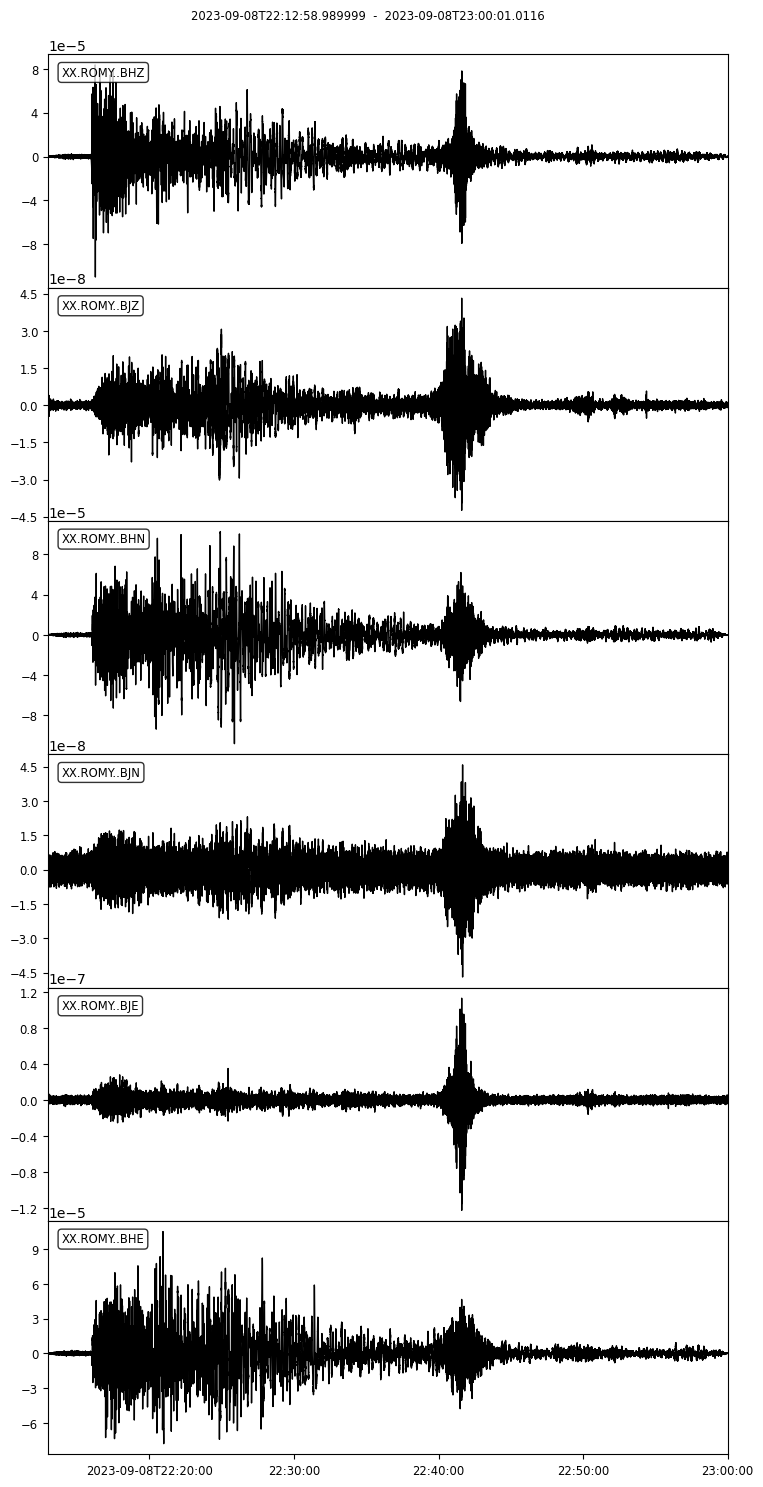

In [14]:
sd.st.plot(equal_scale=False);

## Processing

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [ ]:
# trim the stream to the time window
sd.trim_stream(set_common=True, set_interpolate=False)

# filter the data
sd.filter_data(fmin=config['fmin'], fmax=config['fmax'], output=False)

# apply polarity correction
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

# trim the stream to the time window
sd.trim(UTCDateTime(config['tbeg'])+100, UTCDateTime(config['tend'])-1000)


Now, let's compare the waveforms of the rotation (red) and translational (black) components 

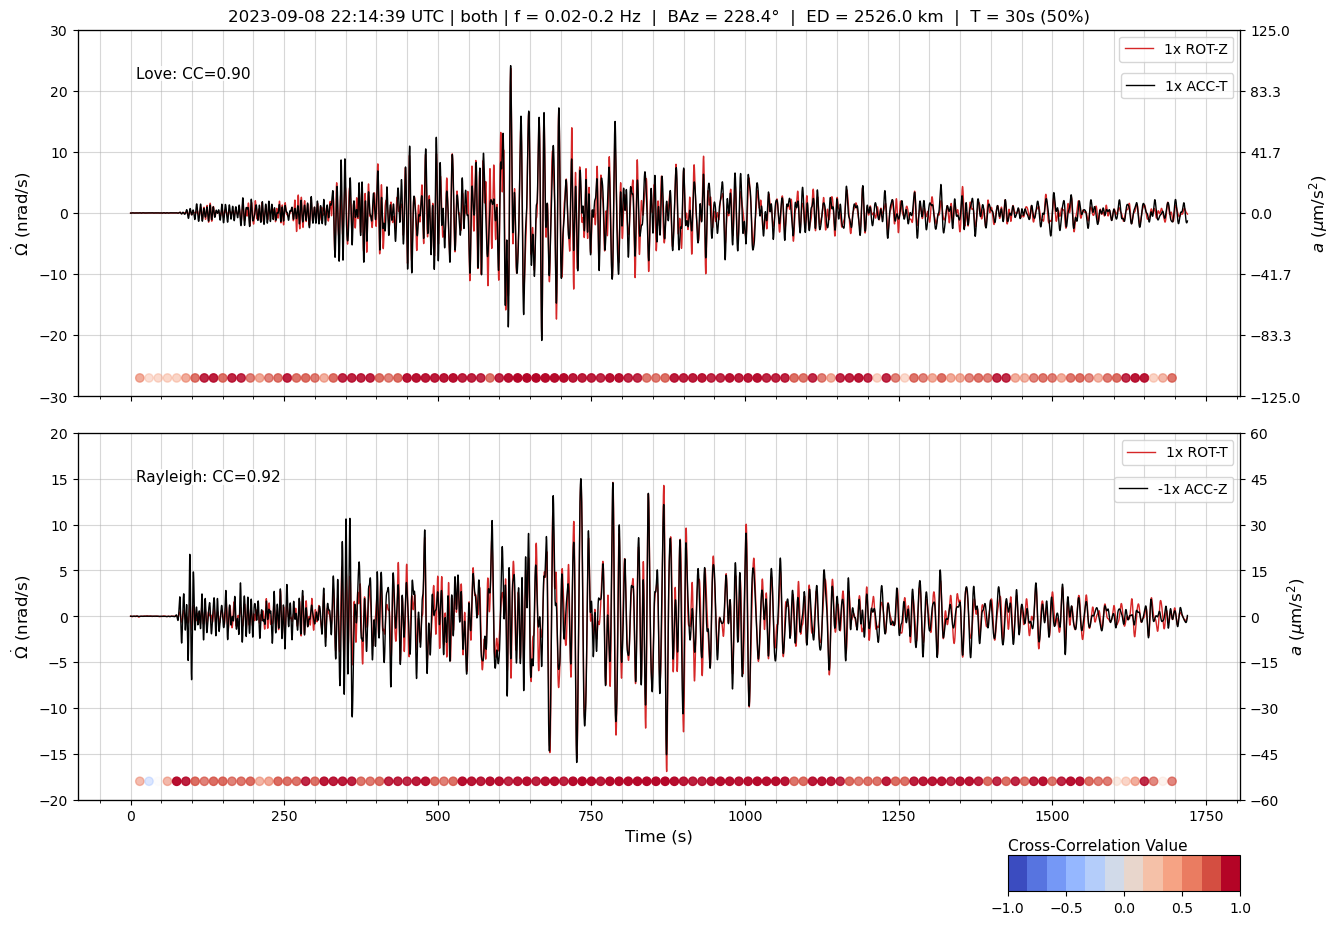

In [19]:
fig = sd.plot_waveform_cc(
    twin_sec=config['twin_sec'],
    twin_overlap=config['twin_overlap'],
    wave_type="both"
)

## Animation

Create an animated visualization of the waveforms and particle motion. This may take a few minutes depending on the duration and frame rate.


In [26]:
# Animation parameters
animation_config = {
    'time_step': 1,        # Time step between frames in seconds
    'duration': 1800,         # Duration of animation in seconds (30 minutes)
    'dpi': 150,              # DPI for saved animation
    'show_arrivals': True,   # Show P and S wave arrival times
    'rotate_zrt': True,      # Rotate to ZRT coordinates
    'tail_duration': 30.0,   # Duration of particle motion tail
    'baz': ev['backazimuth'] # Use theoretical backazimuth
}


In [ ]:
# Create filename with event info
event_time = UTCDateTime(config['origin_time']).strftime('%Y%m%d')
filename = f"ROMY_M{config['magnitude']}_{event_time}_animation.mp4"
save_path = os.path.join(output_dir, filename)


In [ ]:
# Save animation to file
output_dir = "./output/"
os.makedirs(output_dir, exist_ok=True)

print("This may take several minutes...")

# Create and save the animation
anim_saved = animate_waveforms(
    sd=sd,
    time_step=animation_config['time_step'],
    duration=animation_config['duration'],
    save_path=save_path,
    dpi=animation_config['dpi'],
    show_arrivals=animation_config['show_arrivals'],
    rotate_zrt=animation_config['rotate_zrt'],
    tail_duration=animation_config['tail_duration'],
    baz=animation_config['baz']
)

print(f"Animation saved successfully to: {save_path}")
print(f"File size: {os.path.getsize(save_path) / (1024*1024):.1f} MB")


This may take several minutes...
Using backazimuth: 228.3968468832747°
3 Trace(s) in Stream:
XX.ROMY..BJZ | 2023-09-08T22:14:40.011600Z - 2023-09-08T22:43:20.011600Z | 20.0 Hz, 34401 samples
XX.ROMY..BJR | 2023-09-08T22:14:39.999400Z - 2023-09-08T22:43:19.999400Z | 20.0 Hz, 34401 samples
XX.ROMY..BJT | 2023-09-08T22:14:39.986600Z - 2023-09-08T22:43:19.986600Z | 20.0 Hz, 34401 samples 3 Trace(s) in Stream:
XX.ROMY..BHZ | 2023-09-08T22:14:39.989999Z - 2023-09-08T22:43:19.989999Z | 20.0 Hz, 34401 samples
XX.ROMY..BHR | 2023-09-08T22:14:39.990000Z - 2023-09-08T22:43:19.990000Z | 20.0 Hz, 34401 samples
XX.ROMY..BJT | 2023-09-08T22:14:39.986600Z - 2023-09-08T22:43:19.986600Z | 20.0 Hz, 34401 samples
Animation parameters:
Duration: 1720.00s
Time step: 1.000s
Number of frames: 1720
Frame rate: 1.0 fps
Theoretical P-arrival: 2023-09-08T22:16:02.016641Z
Theoretical S-arrival: 2023-09-08T22:20:10.994445Z
